##  Important Rules
**Insert team member names here:**

**Rename this notebook with your MIDAS username as the prefix**

**Choose "Restart Kernel and Run All Cells ..." under "Kernel" before submitting your final notebook**


**Report your Pareto Score: Nov 25**

**Due date of final: December 3rd, 11:59pm**

## Final Project - Fine-tuning and Transfer Learning on Caltech-101 with Model Size and Accuracy Trade-offs

The goal of this project is to classify images from the Caltech-101 dataset using fine-tuning and transfer learning while exploring the trade-offs between accuracy and model size. The dataset includes images from 101 categories, making it a moderately challenging classification task. Given the relatively small dataset size, we will leverage pretrained CNNs for feature extraction, comparing their performance in terms of both accuracy and model size.

### Key Steps:
#### Data Preprocessing:

The Caltech-101 images will be resized, normalized, and split into training, validation, and test sets. Data augmentation techniques may be applied to mitigate overfitting.

#### Transfer Learning:
Three different pretrained models with varying sizes and complexities need to be used: each team can choose which three

For each model, the convolutional layers will be frozen to use their pretrained features, and only the top fully connected layers will be fine-tuned for the Caltech-101 task. For transfer learning, all weights should be trained.

#### Model Training:
The models will be trained using the Caltech-101 dataset.
Techniques such as learning rate scheduling, early stopping, and data augmentation can be applied.
Each model’s training time, accuracy, and memory usage will be monitored to analyze the trade-offs.

#### Trade-off Analysis:
Using the same test dataset, the final accuracy should be computed. Each team should use the same routine to fine-tune and transfer learning three different models. And compare the accuracy vs model sizes. The teams with overall Pareto trade-off will get extra credit.

### Details
1. Implement dataloaders for train (70%), validation (15%) and testing (15%) of caltech101
2. Implement visualization routines to show image, ground truth and predicted labels       
3. Implement fine-tuning routine, using pretrained weights from Pytorch                    
4. Implement transfer learning routine, using pretrained weights                           
5. Use hyperparameter tuning to achieve good accuracy, using validation datasets           
6. GPU must be used                                                                        
7. Conduct experiment at least *3 (three) * pretrained models.                          
8. (Extra credit) The top 3 teams with best accuracy-model size Pareto scores (<0.088) get extra credit

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import math
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.utils as utils # Added this import

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import os

In [2]:
#!pip install --upgrade torchvision

In [3]:
import torchvision
import torchvision.datasets as datasets
dir(torchvision.datasets)


['CIFAR10',
 'CIFAR100',
 'CLEVRClassification',
 'CREStereo',
 'Caltech101',
 'Caltech256',
 'CarlaStereo',
 'CelebA',
 'Cityscapes',
 'CocoCaptions',
 'CocoDetection',
 'Country211',
 'DTD',
 'DatasetFolder',
 'EMNIST',
 'ETH3DStereo',
 'EuroSAT',
 'FER2013',
 'FGVCAircraft',
 'FakeData',
 'FallingThingsStereo',
 'FashionMNIST',
 'Flickr30k',
 'Flickr8k',
 'Flowers102',
 'FlyingChairs',
 'FlyingThings3D',
 'Food101',
 'GTSRB',
 'HD1K',
 'HMDB51',
 'INaturalist',
 'ImageFolder',
 'ImageNet',
 'Imagenette',
 'InStereo2k',
 'KMNIST',
 'Kinetics',
 'Kitti',
 'Kitti2012Stereo',
 'Kitti2015Stereo',
 'KittiFlow',
 'LFWPairs',
 'LFWPeople',
 'LSUN',
 'LSUNClass',
 'MNIST',
 'Middlebury2014Stereo',
 'MovingMNIST',
 'Omniglot',
 'OxfordIIITPet',
 'PCAM',
 'PhotoTour',
 'Places365',
 'QMNIST',
 'RenderedSST2',
 'SBDataset',
 'SBU',
 'SEMEION',
 'STL10',
 'SUN397',
 'SVHN',
 'SceneFlowStereo',
 'Sintel',
 'SintelStereo',
 'StanfordCars',
 'UCF101',
 'USPS',
 'VOCDetection',
 'VOCSegmentation',
 

**This is important: you want to use the common normalization vector from imageNet. Since pretrained weights are based on ImageNet**

In [4]:
imagenet_mean=[0.485, 0.456, 0.406]
imagenet_std=[0.229, 0.224, 0.225]

In [5]:
## routine to print stats of a model
def print_model_weight_stats(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print("{}: Number of fronzen param = {:,d}, number of trainable param = {:,}".format(type(model),frozen_params, trainable_params))

## calculate the pareto value
def compute_pareto_value(acc, msize):
    ## accuracy must be between 0.0 and 0.9999
    ## model size should be in millions, between 1.0 and 900!
    if not ( 0.0 <= acc <= 0.9999):
        raise ValueError ("acc range must be between 0.0 and 0.9999")

    if not (1.0 <= msize <= 900):
        raise ValueError("model sizse must be in millions, between 1.0M and 900M")

    xdist = 0.99 - acc
    ydist = math.log10( np.float64(msize) )

    # assumption: range of accuracy is between 0.99 to 0.80 -> delta 0.2
    # range of model is from 1M to 100M -> delta 2 after taking log
    # hence scale model by 0.1
    ydist = 0.1*ydist

    z_score = math.sqrt( xdist*xdist + ydist*ydist)
    return (z_score)

## use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)

cuda
torch version: 2.9.1+cu128
torch.version.cuda: 12.8


In [ ]:
## now do some work
## example: dataset = datasets.Caltech101(root='./data', download=True, transform=transform)
'''transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for models like ResNet
    transforms.Lambda(lambda image: image.convert("RGB")), # Ensure 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std)
])

dataset = datasets.Caltech101(root="./data",download=True, transform=transform)
classes = dataset.categories'''
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For fully deterministic behavior:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # For DataLoader workers
    def _worker_init(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator().manual_seed(seed)

    return _worker_init, g

worker_init_fn, g = seed_everything(42)

'''transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])'''
dataset = datasets.Caltech101(root='./data', download=True)
classes = dataset.categories

In [7]:
val_size = int(0.15 * len(dataset))
test_size = val_size
train_size = len(dataset) - val_size - test_size

In [ ]:
# Split dataset
train_subset, val_subset, test_subset = random_split(dataset, [train_size, val_size, test_size], generator=g)
train_idx = train_subset.indices
val_idx = val_subset.indices
test_idx = test_subset.indices
print(f"train indices: {train_idx[:10]}, val indices: {val_idx[:10]}, test indices: {test_idx[:10]}")

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])
'''train_base = datasets.Caltech101(root='./data', download=False, transform=train_transform)
val_base = datasets.Caltech101(root='./data', download=False, transform=eval_transform)
test_base = datasets.Caltech101(root='./data', download=False, transform=eval_transform)

train_dataset = Subset(train_base, train_idx)
val_dataset   = Subset(val_base, val_idx)
test_dataset  = Subset(test_base, test_idx)'''

def get_dataset(transform, idx):
    base = datasets.Caltech101(root='./data', download=False, transform=transform)
    dataset = Subset(base, idx)
    return dataset

train_dataset = get_dataset(train_transform, train_idx)
val_dataset = get_dataset(eval_transform, val_idx)
test_dataset = get_dataset(eval_transform, test_idx)
print(f"data shape: {train_dataset[0][0].shape}, val_data shape: {val_dataset[0][0].shape}, test_data shape: {test_dataset[0][0].shape}")
print(f"train dataset size: {len(train_dataset)}, val dataset size: {len(val_dataset)}, test dataset size: {len(test_dataset)}")
'''
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Training and test sets
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=False, num_workers=2)'''


train indices: [2587, 8401, 8543, 3554, 6775, 1527, 7767, 8577, 121, 5090], val indices: [4950, 8321, 1280, 4852, 8055, 64, 238, 5869, 2789, 6390], test indices: [7077, 2505, 6974, 572, 7063, 2355, 8277, 434, 2965, 1756]
data shape: torch.Size([3, 224, 224]), val_data shape: torch.Size([3, 224, 224]), test_data shape: torch.Size([3, 224, 224])
train dataset size: 6075, val dataset size: 1301, test dataset size: 1301


"\ntransform_train = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(mean, std),\n])\n\ntransform_test = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(mean, std),\n])\n\n# Training and test sets\ntrainset = torchvision.datasets.CIFAR100(root='./data', train=True,\n                                         download=True, transform=transform_train)\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,\n                                          shuffle=True, num_workers=2)\n\ntestset = torchvision.datasets.CIFAR100(root='./data', train=False,\n                                        download=True, transform=transform_test)\ntestloader = torch.utils.data.DataLoader(testset, batch_size=200,\n                                         shuffle=False, num_workers=2)"

In [9]:
len(train_dataset)

6075

In [10]:
len(val_dataset)

1301

In [11]:
len(test_dataset)

1301

In [12]:
## data loader
## Your code here.

#DataLoaders



batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)



In [13]:

def denormalize(img_tensor):
    mean = torch.tensor(imagenet_mean, dtype=img_tensor.dtype, device=img_tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(imagenet_std, dtype=img_tensor.dtype, device=img_tensor.device).view(1, 3, 1, 1)
    return img_tensor * std + mean

def show_batch(dataloader, classes):
    inputs, labels = next(iter(dataloader))
    inputs = denormalize(inputs)
    img_grid = utils.make_grid(inputs, nrow=4)
    npimg = img_grid.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Ground Truth: " + ", ".join([classes[l] for l in labels]))
    plt.show()

#show_batch(test_loader, classes)


#### Fine tuning, use ResNet18

In [14]:
## Your code
#Load Pretrained ResNet18


frozen_resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in frozen_resnet18.parameters():
    param.requires_grad = False

# set up unfrozen final layer
frozen_resnet18.fc = nn.Linear(frozen_resnet18.fc.in_features, len(classes))
frozen_resnet18 = frozen_resnet18.to(device)

# Print stats after fine-tuning setup
print_model_weight_stats(frozen_resnet18)
frozen_resnet18 = frozen_resnet18.to(device)




<class 'torchvision.models.resnet.ResNet'>: Number of fronzen param = 11,176,512, number of trainable param = 51,813


In [15]:
#Loss & Optimizer
# -----------------------------
def get_loss_and_opt(model, lr, loss='ce'):
    if loss == 'ce':
        criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    return criterion, optimizer
lr = 1e-2
criterion, optimizer = get_loss_and_opt(frozen_resnet18, lr, 'ce')

In [16]:
## Your code
import torch.nn.functional as F

num_classes = 101  # Caltech101 has 101 categories

mixup_or_cutmix = v2.RandomChoice([
    v2.MixUp(num_classes=num_classes, alpha=0.2),
    v2.CutMix(num_classes=num_classes, alpha=1.0),
])

def ce_loss(logits, target):
    if target.dtype in (torch.long, torch.int64):  # hard labels
        return F.cross_entropy(logits, target)
    # soft labels: target shape [N, C]
    log_prob = F.log_softmax(logits, dim=1)
    return -(target * log_prob).sum(dim=1).mean()

#Training
def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def run_epoch(loader, model, optimizer, criterion, device, train_mode: bool = True):
    model.train(train_mode)
    model.to(device)
    total_loss, total_acc, n = 0.0, 0.0, 0
    # n is the number of the samples

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        if train_mode:
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(x)
                loss = criterion(logits, y)

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

def train_model(model, train_loader, val_loader, criterion, optimizer, save_path, epochs=5, scheduler=None, hard_aug=False, min_delta=0.001, patience=5):
    best_val_loss = 999999.99
    epochs_no_improve = 0

    for ep in range(1, 1 + epochs):
        model.train(True)
        total_loss, total_acc, n = 0.0, 0.0, 0

        for x, y in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            if hard_aug:
                x, y_mixed = mixup_or_cutmix(x, y) ## changed

            optimizer.zero_grad(set_to_none=True)

            logits = model(x)
            if hard_aug:
                loss = ce_loss(logits, y_mixed)  ## changed!
            else:
                loss = ce_loss(logits, y)

            loss.backward()
            optimizer.step()

            bs = y.size(0)
            total_loss += loss.item() * bs
            total_acc  += accuracy(logits, y) * bs
            n += bs

        train_loss = total_loss / n
        train_acc = total_acc / n
        val_loss,   val_acc   = run_epoch(val_loader, model,  optimizer, criterion, device, train_mode=False)
        if scheduler is not None:
            scheduler.step(val_loss)

        print(f"Epoch {ep:02d}/{epochs} | "
            f"train loss {train_loss:.4f} acc {train_acc*100:.2f}% | "
            f"val loss {val_loss:.4f} acc {val_acc*100:.2f}% ")
        # Save the best model by validation loss
        if val_loss < best_val_loss:
            torch.save({"model_state": model.state_dict(),}, save_path)
            print(f"  ↳ Saved new best to {save_path}")

        if val_loss < best_val_loss - min_delta:
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"no improvement for {epochs_no_improve} epochs")
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {ep} epochs.")
            break

        if val_loss < best_val_loss:
            best_val_loss = val_loss
        

save_path = "fres18_best.pt"
train_model(frozen_resnet18, train_loader, val_loader, criterion, optimizer, save_path)


Epoch 01/5 | train loss 2.4351 acc 57.25% | val loss 1.1059 acc 76.71% 
  ↳ Saved new best to fres18_best.pt
Epoch 02/5 | train loss 1.3545 acc 71.79% | val loss 0.8548 acc 82.71% 
  ↳ Saved new best to fres18_best.pt
Epoch 03/5 | train loss 1.3519 acc 74.75% | val loss 1.0477 acc 80.55% 
no improvement for 1 epochs
Epoch 04/5 | train loss 1.3459 acc 75.95% | val loss 1.0520 acc 80.94% 
no improvement for 2 epochs
Epoch 05/5 | train loss 1.3985 acc 76.84% | val loss 1.3534 acc 80.94% 
no improvement for 3 epochs


Test Loss: 1.4578, Test Accuracy: 79.25%


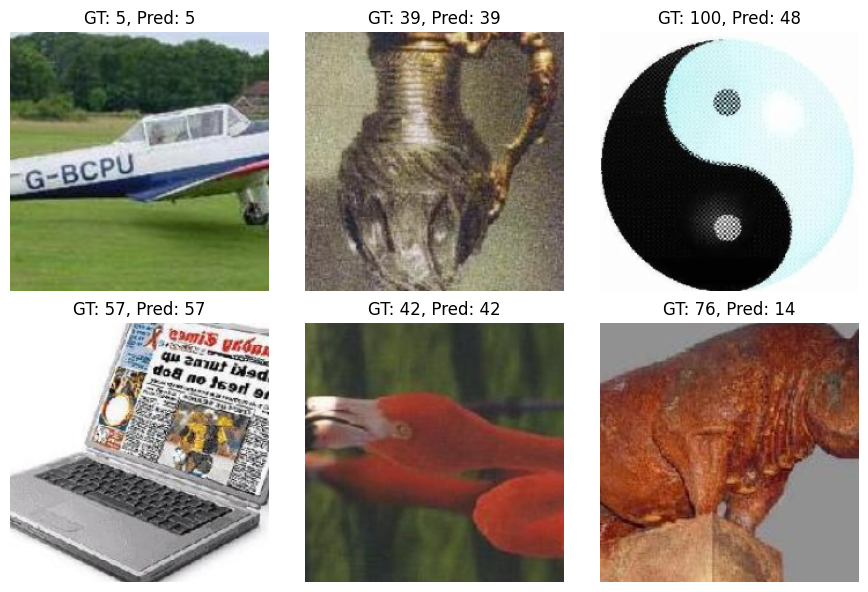

In [17]:
## testing loss

#Testing routine
def run_test_dataset(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


run_test_dataset(frozen_resnet18, test_loader)


#Visualization pediction


def visualize_predictions(model, dataset, device, n_rows: int = 2, n_cols: int = 3):
    """
    Run inference on the first n_samples of a dataset and plot them
    with ground-truth (GT) and predicted (Pred) labels.

    Parameters
    ----------
    model : torch.nn.Module
        Trained PyTorch model.
    dataset : torch.utils.data.Dataset
        Dataset providing (image, label) pairs.
    device : torch.device
        Device to run inference on.
    n_rows : int, optional
        Number of rows, default = 2.
    n_cols : int, optional
        Number of cols, default = 3
    """
    model.eval()
    n_samples = n_rows * n_cols

    ### Your code here
    inputs, labels = [], []
    for i in range(n_samples):
        input, label = dataset[i]
        inputs.append(input)
        labels.append(label)

    with torch.no_grad():
        x_batch = torch.stack(inputs)
        x_batch = x_batch.to(device)
        logits = model(x_batch)
        preds = logits.argmax(dim=1).cpu().numpy()

    # Denormalize and move to CPU
    x_batch_cpu = denormalize(x_batch.cpu())

    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    
    for i in range(n_samples):
        plt.subplot(n_rows, n_cols, i + 1)
        img = x_batch_cpu[i]
        img = img.permute(1,2,0).numpy()
        plt.imshow(img)
        plt.title(f"GT: {labels[i]}, Pred: {preds[i]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(frozen_resnet18, test_dataset, device)


In [18]:
## ResNet18, transfer learning
## code
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(classes))
resnet18 = resnet18.to(device)
lr=1e-4
criterion, optimizer = get_loss_and_opt(resnet18, lr, 'ce')
save_path = "res18_best.pt"
train_model(resnet18, train_loader, val_loader, criterion, optimizer, save_path)


Epoch 01/5 | train loss 2.3179 acc 51.47% | val loss 0.9338 acc 80.02% 
  ↳ Saved new best to res18_best.pt
Epoch 02/5 | train loss 1.0419 acc 78.80% | val loss 0.5164 acc 88.47% 
  ↳ Saved new best to res18_best.pt
Epoch 03/5 | train loss 0.7417 acc 83.87% | val loss 0.3985 acc 89.85% 
  ↳ Saved new best to res18_best.pt
Epoch 04/5 | train loss 0.5846 acc 87.06% | val loss 0.3297 acc 91.78% 
  ↳ Saved new best to res18_best.pt
Epoch 05/5 | train loss 0.5051 acc 88.46% | val loss 0.2951 acc 91.85% 
  ↳ Saved new best to res18_best.pt


In [19]:
## testing loss
run_test_dataset(resnet18, test_loader)

Test Loss: 0.3660, Test Accuracy: 91.31%


(0.36596745252609253, 91.31437355880092)

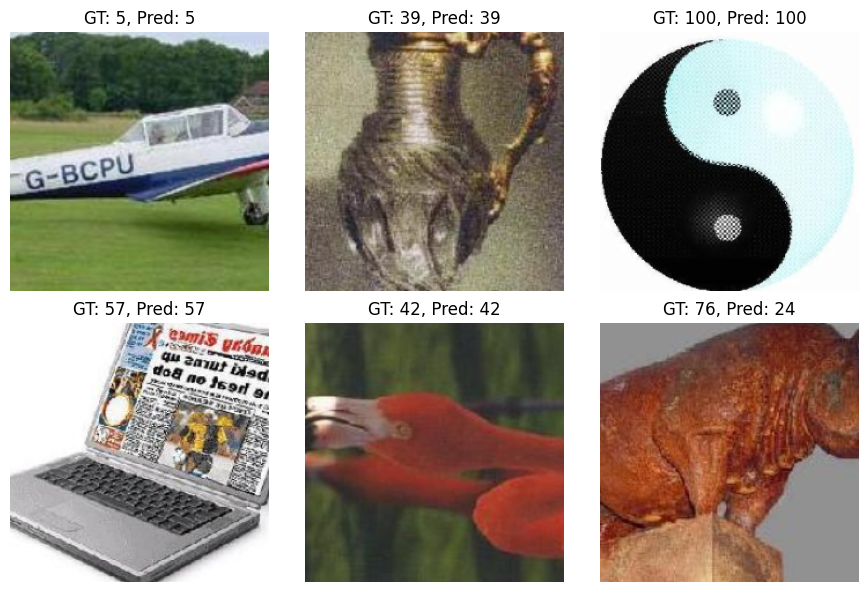

In [20]:
visualize_predictions(resnet18, test_dataset, device)

#### ShuffleNet


In [21]:
## fine tuning shuffle Net
## repeat
frozen_shuffle_v2_x1_0 = models.shufflenet_v2_x1_0(weights='DEFAULT')
for param in frozen_shuffle_v2_x1_0.parameters():
    param.requires_grad = False
frozen_shuffle_v2_x1_0.fc = nn.Linear(frozen_shuffle_v2_x1_0.fc.in_features, len(classes))
frozen_shuffle_v2_x1_0 = frozen_shuffle_v2_x1_0.to(device)
print_model_weight_stats(frozen_shuffle_v2_x1_0)
lr=1e-3
criterion, optimizer = get_loss_and_opt(frozen_shuffle_v2_x1_0, lr, 'ce')
save_path = "frozen_shuffle_v2_x1_0_best.pt"

train_model(frozen_shuffle_v2_x1_0, train_loader, val_loader, criterion, optimizer, save_path)

<class 'torchvision.models.shufflenetv2.ShuffleNetV2'>: Number of fronzen param = 1,253,604, number of trainable param = 103,525
Epoch 01/5 | train loss 4.1937 acc 16.58% | val loss 3.8504 acc 26.06% 
  ↳ Saved new best to frozen_shuffle_v2_x1_0_best.pt
Epoch 02/5 | train loss 3.7084 acc 24.03% | val loss 3.4323 acc 26.13% 
  ↳ Saved new best to frozen_shuffle_v2_x1_0_best.pt
Epoch 03/5 | train loss 3.3675 acc 27.36% | val loss 3.0785 acc 33.74% 
  ↳ Saved new best to frozen_shuffle_v2_x1_0_best.pt
Epoch 04/5 | train loss 3.0954 acc 31.97% | val loss 2.7804 acc 40.51% 
  ↳ Saved new best to frozen_shuffle_v2_x1_0_best.pt
Epoch 05/5 | train loss 2.8596 acc 37.02% | val loss 2.5548 acc 48.65% 
  ↳ Saved new best to frozen_shuffle_v2_x1_0_best.pt


In [22]:
## testing loss
run_test_dataset(frozen_shuffle_v2_x1_0, test_loader)

Test Loss: 2.6230, Test Accuracy: 44.97%


(2.622995649896017, 44.965411222136815)

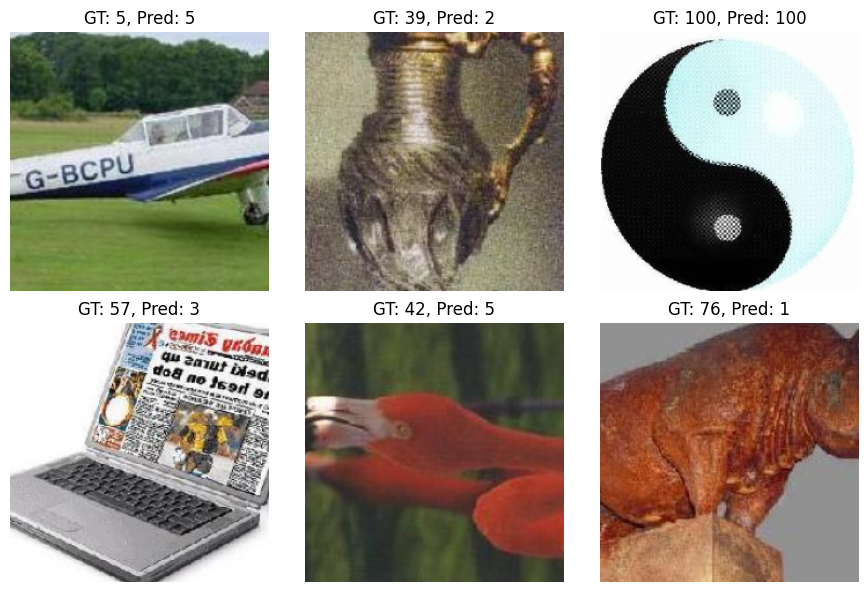

In [23]:
## do a quick plot
## your code
visualize_predictions(frozen_shuffle_v2_x1_0, test_dataset, device)

In [24]:
## transfer learning of shuffleNet
##
## fine tuning shuffle Net
## repeat
shuffle_v2_x1_0 = models.shufflenet_v2_x1_0(weights='DEFAULT')
shuffle_v2_x1_0.fc = nn.Linear(shuffle_v2_x1_0.fc.in_features, len(classes))
shuffle_v2_x1_0 = shuffle_v2_x1_0.to(device)
print_model_weight_stats(shuffle_v2_x1_0)
lr = 1e-3
criterion, optimizer = get_loss_and_opt(shuffle_v2_x1_0, lr, 'ce')
save_path = "shuffle_v2_x1_0_best.pt"

train_model(shuffle_v2_x1_0, train_loader, val_loader, criterion, optimizer, save_path)

<class 'torchvision.models.shufflenetv2.ShuffleNetV2'>: Number of fronzen param = 0, number of trainable param = 1,357,129
Epoch 01/5 | train loss 3.2791 acc 29.88% | val loss 2.3571 acc 43.27% 
  ↳ Saved new best to shuffle_v2_x1_0_best.pt
Epoch 02/5 | train loss 1.9552 acc 51.93% | val loss 1.0861 acc 69.72% 
  ↳ Saved new best to shuffle_v2_x1_0_best.pt
Epoch 03/5 | train loss 1.2926 acc 66.14% | val loss 0.7886 acc 78.86% 
  ↳ Saved new best to shuffle_v2_x1_0_best.pt
Epoch 04/5 | train loss 1.0848 acc 70.67% | val loss 0.6136 acc 82.86% 
  ↳ Saved new best to shuffle_v2_x1_0_best.pt
Epoch 05/5 | train loss 0.9020 acc 75.19% | val loss 0.5054 acc 85.01% 
  ↳ Saved new best to shuffle_v2_x1_0_best.pt


In [25]:
## testing loss
run_test_dataset(shuffle_v2_x1_0, test_loader)

Test Loss: 0.5989, Test Accuracy: 82.55%


(0.5989498452442449, 82.55188316679477)

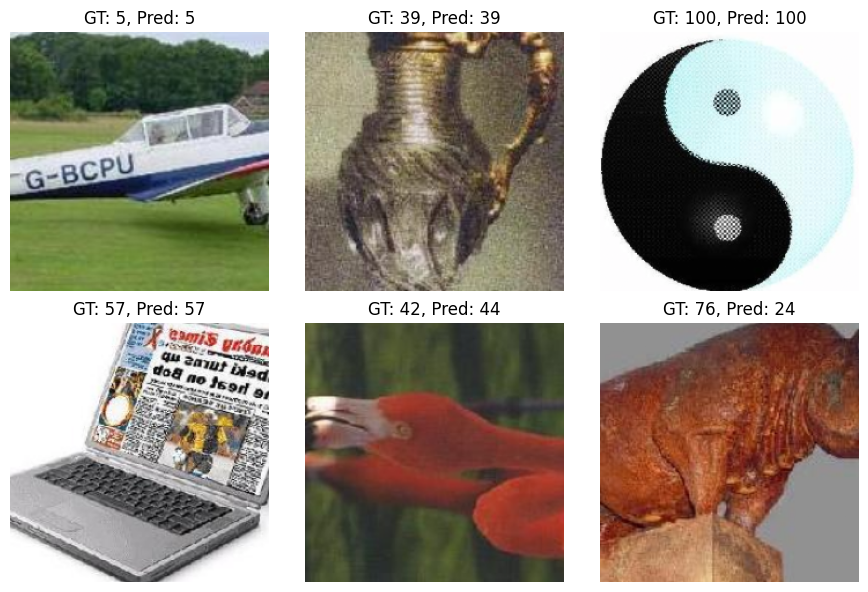

In [26]:
## do a quick plot
## your code
visualize_predictions(shuffle_v2_x1_0, test_dataset, device)

#### You have to implement the third model

In [27]:
## frozen effnet
f_effnet_b0 = models.efficientnet_b0(weights='DEFAULT')
for param in f_effnet_b0.parameters():
    param.requires_grad = False
f_effnet_b0.classifier[1] = nn.Linear(f_effnet_b0.classifier[1].in_features, len(classes))
f_effnet_b0 = f_effnet_b0.to(device)
print_model_weight_stats(f_effnet_b0)
lr = 1e-3
criterion, optimizer = get_loss_and_opt(f_effnet_b0, lr, 'ce')
save_path = "f_effnet_b0_best.pt"

train_model(f_effnet_b0, train_loader, val_loader, criterion, optimizer, save_path)



<class 'torchvision.models.efficientnet.EfficientNet'>: Number of fronzen param = 4,007,548, number of trainable param = 129,381
Epoch 01/5 | train loss 2.3173 acc 55.93% | val loss 1.0002 acc 84.32% 
  ↳ Saved new best to f_effnet_b0_best.pt


KeyboardInterrupt: 

In [ ]:
## testing loss
run_test_dataset(f_effnet_b0, test_loader)


In [ ]:
## do a quick plot
visualize_predictions(f_effnet_b0, test_dataset, device)

In [ ]:
# transfer learning effnet
effnet_b0 = models.efficientnet_b0(weights='DEFAULT')
effnet_b0.classifier[1] = nn.Linear(effnet_b0.classifier[1].in_features, len(classes))
effnet_b0 = effnet_b0.to(device)
print_model_weight_stats(effnet_b0)
lr = 1e-3
criterion, optimizer = get_loss_and_opt(effnet_b0, lr, 'ce')
save_path = "effnet_b0_best.pt"

train_model(effnet_b0, train_loader, val_loader, criterion, optimizer, save_path)




In [ ]:
## testing loss
run_test_dataset(effnet_b0, test_loader)



In [ ]:
## do a quick plot
visualize_predictions(effnet_b0, test_dataset, device)

#### Report the Pareto value here

In [ ]:
## for ResNet18, testing accuracy is for transfer learning
acc = 0.9331

## the model size is copied from print command
msize = 11228325.0/1000000

In [ ]:
print("ResNet18 Pareto score is {:.4f}".format( compute_pareto_value(acc, msize)))

In [ ]:
## for shufflenet
acc = 0.867
msize = 1357129.0/1000000

In [ ]:
print("ShuffleNet_v2_x1.0 pareto score is {:.4f}".format( compute_pareto_value(acc, msize)))

In [ ]:
## for efficientnet_b0
acc = 0.9039
msize = 4136929.0/1000000

In [ ]:
print("EfficientNet_b0 pareto score is {:.4f}".format( compute_pareto_value(acc, msize)))